In [74]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import glob
from skimage.color import rgb2gray
from skimage.morphology import remove_small_holes, remove_small_objects
import rawpy
from tqdm import tqdm
from measure import *
from IPython.display import HTML
import matplotlib.animation
from scipy.stats import skewnorm

# Define functions

In [64]:
def findWL(polygon, densityRatio=.917, epsilon = 0.001):
    """Finds the water level for an ice polygon immersed in water, with prescribed precision. 

    Args:
        polygon (np.array): polygon coordinates
        densityRatio (float, optional): density ratio of the two fluids. Defaults to .917, ratio of ice/fresh water.
        epsilon (float, optional): precisio of calculation. Defaults to 0.001.

    Returns:
        float: water level of the immersed polygon
    """    
    originalArea = PolyArea(polygon[:,0],polygon[:,1])
    ymin, ymax = min(polygon[:,1]),max(polygon[:,1])
    mmin, mmax = ymin,ymax
    attempt = ymin + (ymax-ymin) * densityRatio 
    pgbelow = makePolygonBelow(polygon,attempt)
    # plt.plot(pgbelow[:,0],pgbelow[:,1],label='initial attempt')

    newArea = PolyArea(pgbelow[:,0],pgbelow[:,1])

    ratio = newArea/originalArea

    while abs(ratio-densityRatio) > epsilon:
        if ratio-densityRatio > 0:
            mmax = attempt
        else:
            mmin = attempt
        attempt = (mmin+mmax)/2
        pgbelow_ = makePolygonBelow(polygon,attempt)
        newArea_ = PolyArea(pgbelow_[:,0],pgbelow_[:,1])
        ratio = newArea_/originalArea
        # print(f'{newArea_:.2f}',ratio)

    return attempt

def makePolygonBelow(polygon, level):
    """Draws the part of a polygon which is below a horizontal level. Returns a list of coordinates. 

    Args:
        polygon (np.array): polygon coordinates
        level (float): horizontal level 

    Returns:
        np.array: coordinates of polygon below level
    """    
    newY = np.where(polygon[:,1]<level,polygon[:,1],level)
    polygonBELOW = polygon.copy()
    polygonBELOW[:,1] = newY
    return polygonBELOW
def PolyArea(x,y):
    """Returns area of a polygon given the x,y-coordinates of its points

    Args:
        x (np.array): x-coordinates
        y (np.array): y-coordinates

    Returns:
        _type_: _description_
    """    
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

In [42]:
directory = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/2024-02-13/2nd/'
calibration = 0.158360898494720 # mm/px

imagesDir = []
for imageDir in glob.glob(directory+'*.NEF'):
    imagesDir.append(imageDir)
imagesDir = np.sort(imagesDir)

# TEST
testImg = rgb2gray(rawpy.imread(imagesDir[143]).postprocess()[500:3750,1000:4500])
print(imagesDir[143])

/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/2024-02-13/2nd/DSC_8301.NEF


# Test

In [43]:
def analyse_image(img):
    dark = np.mean(img[:50,:])
    threhsholded = np.where(img>dark*5,1,0)
    holesFilled = remove_small_holes(threhsholded,area_threshold=1e4)
    spotsRemoved = remove_small_objects(holesFilled,min_size=1e4)
    return np.where(spotsRemoved,img,np.nan)
im = plt.imshow(analyse_image(testImg))
cbar = plt.colorbar(im, ax=plt.gca())
print(np.sum(np.where(~np.isnan(analyse_image(testImg)))))

/Users/edoardo/opt/anaconda3/envs/meltingAnaconda/lib/python3.9/site-packages/skimage/_shared/utils.py:157: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  return func(*args, **kwargs)


<IPython.core.display.Javascript object>

10365908731


# Read all images

In [44]:
# plt.figure()
areas = []
for it,imageDir in enumerate(tqdm(imagesDir[109:200:])):
    # plt.figure()
    currentImage = rgb2gray(rawpy.imread(imageDir).postprocess()[500:3750,1000:4500])
    # plt.imshow(analyse_image(currentImage))
    # plt.title(f'{imageDir[-10:]}')
    # plt.show()
    areas.append(np.sum(np.where(~np.isnan(analyse_image(currentImage)))))

  0%|          | 0/91 [00:02<?, ?it/s]


KeyboardInterrupt: 

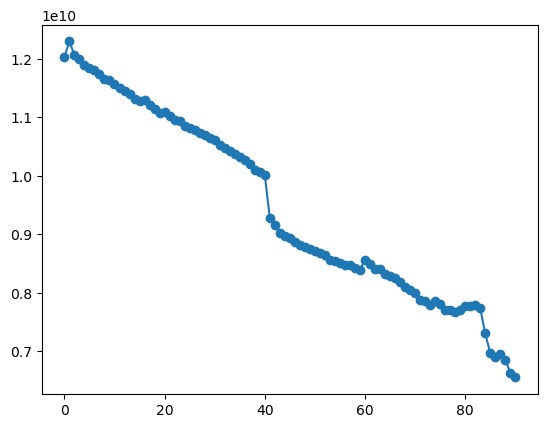

In [ ]:
plt.figure()
plt.plot(areas,marker='o')
plt.show()

# Simulation of rotations

## Initial situation

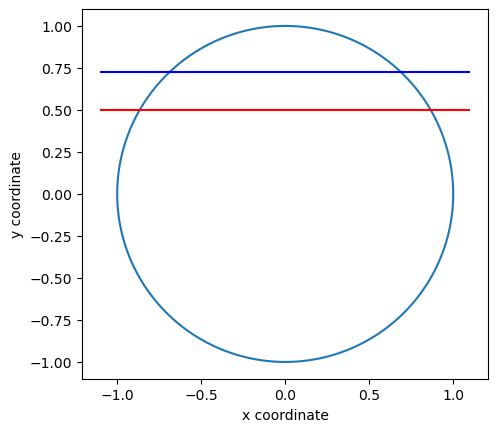

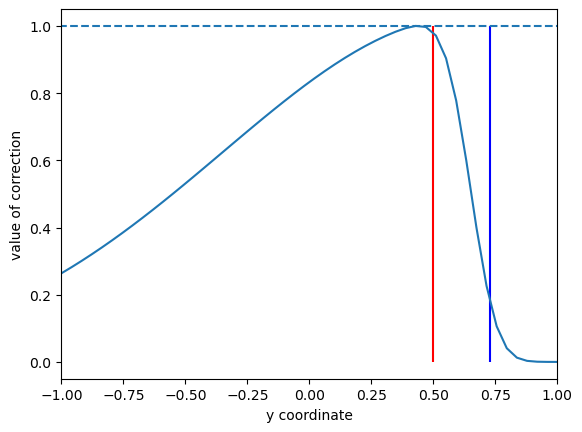

In [123]:
%matplotlib inline
phi = np.linspace(0,2*np.pi,200)
radius_circle = 1
fresh_layer = radius_circle*(1-1/2)
x_circle = radius_circle*np.cos(phi)
y_circle = radius_circle*np.sin(phi)
water_level = findWL(np.vstack((x_circle,y_circle)).T)
plt.figure()
plt.plot(y_circle,x_circle)
plt.hlines(water_level,-1.1*radius_circle,1.1*radius_circle,colors='blue')
plt.hlines(fresh_layer,-1.1*radius_circle,1.1*radius_circle,colors='red')
plt.gca().set_aspect('equal')
plt.xlabel('x coordinate')
plt.ylabel('y coordinate')
plt.show()

plt.figure()
plt.vlines(water_level,0,1,colors='blue')
plt.vlines(fresh_layer,0,1,colors='red')
plt.hlines(1,-1.1*radius_circle,1.1*radius_circle,linestyles='--')
xspan = np.linspace(-radius_circle,radius_circle)
plt.plot(xspan, 1.29*skewnorm.pdf(xspan-1.3*fresh_layer, -12))
plt.xlim(-radius_circle,radius_circle)
plt.xlabel('y coordinate')
plt.ylabel('value of correction')
plt.show()

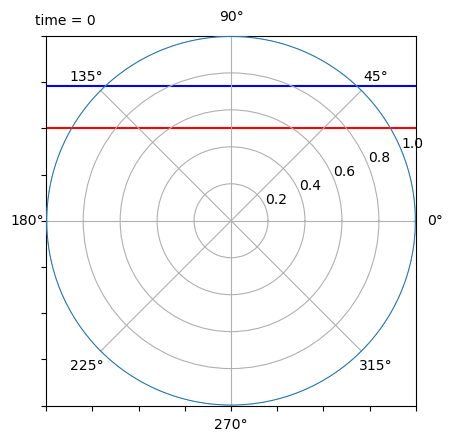

In [148]:
t = range(50)

water_levels = []

for time in t:
    if time == 0:
        radii = np.ones_like(phi)
        water_level = findWL(np.vstack((x_circle,y_circle)).T)
        water_levels.append(water_level)
    else:
        if time == 1:
            radii = np.vstack((radii,radii))
        else:
            radii = np.vstack((radii,radii[-1]))
        
        y = radii[time,:]*np.sin(phi)
        x = radii[time,:]*np.cos(phi)
        water_level = findWL(np.vstack((x,y)).T)
        water_levels.append(water_level)
        for ia,angle in enumerate(phi):
            point_y = radii[time,ia]*np.sin(angle)
            point_x = radii[time,ia]*np.cos(angle)
            if point_y > water_level:
                continue # let's start with no melting
            elif point_y > fresh_layer and point_y < water_level:
                radii[time,ia] -= 4e-3*1.29*skewnorm.pdf(point_y-1.3*fresh_layer, -12)
            else:
                radii[time,ia] -= 4e-3*1.29*skewnorm.pdf(point_y-1.3*fresh_layer, -12)

fig = plt.figure()
ax = fig.add_subplot()
axp = fig.add_axes(ax.get_position().bounds, polar=True, frameon=False)

ax.axhline(fresh_layer,-1.1*radius_circle,1.1*radius_circle,color='red')

l, = axp.plot([],[])
text = axp.text(.75*np.pi,1.5,[])
water_level_anim, = ax.plot([],[],color='blue')

def animate(i):
    l.set_data(phi, radii[i,:])
    text.set_text(f'time = {i}')
    water_level_anim.set_data([-radius_circle,radius_circle],[water_levels[i],water_levels[i]])

ax.set_aspect('equal')
ax.set_xlim(-radius_circle,radius_circle)
ax.set_ylim(-radius_circle,radius_circle)
axp.set_rlim(0,radius_circle)
ax.set_yticklabels('')
ax.set_xticklabels('')

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(t))
HTML(ani.to_jshtml())